## Introduction and Problem Formulation

This notebook investigates how different execution strategies affect the performance of stochastic gradient descent (SGD), focusing on system-level behaviour rather than improvements in model predictive performance.

The objective is to analyse execution-level performance characteristics while keeping algorithmic components fixed, allowing system-level effects to be isolated.


## Abstract

This notebook investigates how different execution strategies influence the system-level performance of stochastic gradient descent (SGD) while maintaining identical algorithmic behaviour. The analysis compares serial execution, shared-memory parallelism using lock-free updates, and distributed data-parallel training with periodic model averaging. Evaluation focuses on execution efficiency, scalability behaviour, synchronization overhead, and practical runtime constraints.

Initial observations revealed differences between theoretical expectations of parallel speedup and observed performance, motivating additional experiments exploring scaling behaviour, communication frequency, and workload sensitivity. Results highlight that effective scalability depends not only on algorithm design but also on workload characteristics, execution environment, and system architecture, emphasizing the importance of systems-level thinking in machine learning workflows.


## Experiment Evolution Overview

This notebook follows an iterative experimental workflow derived from the initial design proposed in Assignment 1. Rather than presenting independent implementations, the experiments are organized as successive design stages to evaluate how execution strategies influence system-level performance.

The experimental process evolves through multiple design versions:

- **Version 0 (Initial Design):** Serial SGD baseline used as a reference for performance measurement.
- **Version 1:** Shared-memory parallel implementation inspired by lock-free updates (HOGWILD-style).
- **Version 2:** Distributed data-parallel implementation with periodic synchronization.
- **Version 3:** Additional investigative experiments introduced after observing unexpected performance behaviour, including scaling analysis and synchronization frequency studies.

The objective is to understand how practical system constraints affect theoretical expectations about parallel scalability and execution efficiency.

The following section presents a structured overview of the notebook organization, outlining how these design stages are implemented throughout the experimental workflow.



## How to Read This Notebook

This notebook follows a structured experimental progression designed to analyze system-level behaviour of stochastic gradient descent (SGD) under different execution strategies. Rather than presenting independent experiments, each section builds upon observations from previous stages.

Early sections introduce the experimental setup and baseline implementation. Subsequent sections progressively extend the execution model from serial training to shared-memory parallelism and distributed data-parallel simulation. Later analysis sections investigate scalability behaviour and execution trade-offs motivated by earlier experimental observations.

Some sections may appear conceptually related (for example, design overview versus retrospective analysis). This is intentional: early sections describe the planned experimental workflow, while later sections reflect on completed experiments to derive systems-level insights.

Readers may follow the notebook sequentially to observe how design decisions evolve through experimentation, or navigate directly to implementation or analysis sections depending on interest.


## Notebook Structure Overview

This notebook follows a structured experimental workflow designed to analyse system-level behaviour of stochastic gradient descent (SGD) under different execution strategies. The organization reflects a progressive design evolution, where each implementation builds upon prior observations to investigate execution efficiency, scalability, and system-level trade-offs.

The notebook is organised as follows:

---

### Introduction and Problem Formulation
Defines the motivation, scope, and objectives of analysing execution strategies from a systems perspective, emphasizing execution behaviour rather than predictive performance improvements.

---

### Abstract
Provides a concise overview of experimental goals, methodology, and key insights derived from the study.

---

### Experiment Evolution Overview
Introduces the iterative experimental design and explains how execution strategies evolve across multiple implementation stages.

---

### Experimental Design and Setup
Establishes controlled experimental conditions, including:
- Reproducibility setup
- Experimental assumptions
- Hardware configuration
- Experimental workflow

This section ensures fair comparison across execution models.

---

### Execution Model Implementations
Implementation of progressively complex execution strategies:

- Version 0 — Serial SGD Baseline
- Version 1 — Shared-Memory Parallel SGD (Lock-Free / HOGWILD-style)
- Version 2 — Distributed Data-Parallel SGD (Model Averaging)

All implementations maintain identical algorithmic behaviour to isolate system-level effects.

---

### Evaluation Framework
Defines how performance is assessed and interpreted:

- Fairness of comparison and controlled variables
- Evaluation methodology (training time, accuracy, speedup)
- Analytical framing focused on systems-level behaviour

---

### Experimental Results Summary
Presents comparative performance analysis, visualizations, and initial systems-level observations across execution strategies.

---

### Version 3 — Extended Analysis
Additional experiments motivated by initial findings, including:

- Parallel scaling behaviour
- Synchronization frequency analysis
- Workload scalability experiments

These analyses explore how execution models respond under changing system conditions.

---

### Consolidated Visualization and Comparative Analysis
Unified performance visualizations and structured comparison tables supporting systems-level interpretation.

---

### Design Evolution Summary
Retrospective synthesis showing how experimental observations guided design refinements.

---

### Methodology Reflection and Practical Considerations
Includes:

- Experimental methodology summary
- Practical limitations
- Systems-level trade-off analysis

---

### Key Findings Summary
Consolidated insights highlighting relationships between workload characteristics, execution environment, and scalability behaviour.

---

### Future Work and Extensions
Brief discussion of practical directions for extending experiments beyond the current controlled setup.


## Experimental Design and Setup


### Experimental Setup and Reproducibility

To ensure fair comparison between execution strategies, all experiments were conducted under controlled conditions:

- The same dataset, preprocessing pipeline, and model architecture were used across all experiments.
- The learning rate, number of epochs, and optimization procedure were kept constant.
- Training and evaluation were performed using a fixed train-test split.
- Random seeds were set to ensure reproducibility of results.
- Performance measurements were obtained using wall-clock execution time.

By controlling these variables, differences observed between serial, parallel, and distributed implementations reflect execution strategy rather than algorithmic or data variations.

Hardware configuration is reported for transparency when interpreting execution performance.


### Experimental Assumptions

The experiments operate under several simplifying assumptions intended to isolate system-level behaviour:

- Distributed execution is simulated within a single runtime environment rather than across physical machines.
- Network latency and real communication delays are approximated through synchronization steps rather than measured directly.
- The dataset size is relatively small, emphasizing execution overhead effects rather than large-scale computational performance.

These assumptions allow controlled comparison of execution strategies while highlighting conceptual system-level trade-offs.


In [1]:
!lscpu


Architecture:                x86_64
  CPU op-mode(s):            32-bit, 64-bit
  Address sizes:             48 bits physical, 48 bits virtual
  Byte Order:                Little Endian
CPU(s):                      2
  On-line CPU(s) list:       0,1
Vendor ID:                   AuthenticAMD
  Model name:                AMD EPYC 7B12
    CPU family:              23
    Model:                   49
    Thread(s) per core:      2
    Core(s) per socket:      1
    Socket(s):               1
    Stepping:                0
    BogoMIPS:                4499.99
    Flags:                   fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pg
                             e mca cmov pat pse36 clflush mmx fxsr sse sse2 ht s
                             yscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constan
                             t_tsc rep_good nopl nonstop_tsc cpuid extd_apicid t
                             sc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 s
                             se4_2 

### Design and Experimental Setup


The design is translated into practice using a controlled experimental setup implemented in Python. Hardware configuration and reproducibility settings are recorded to ensure fair performance comparison.

The design introduces progressively complex execution models:

- Serial SGD baseline
- Shared-memory parallel SGD
- Distributed data-parallel SGD

All implementations maintain identical optimization behaviour to isolate system-level effects.



### Experimental Workflow

The experiments follow a progressive workflow where execution complexity increases step by step:

1. Establish a serial baseline to understand core optimization behaviour.
2. Introduce shared-memory parallelism to study intra-machine execution effects.
3. Simulate distributed data-parallel training to analyse communication and synchronization trade-offs.

This structured progression allows performance differences to be interpreted relative to simpler execution models.


In [2]:
############################################################
# STEP 1 — Environment setup and dataset preparation
#
# Purpose:
# - Prepare environment for experiments
# - Load dataset for binary classification
# - Create consistent train/test split
# - Apply feature scaling for SGD stability
############################################################

# ===== Import required libraries =====

import numpy as np
import pandas as pd
import time
import platform
import multiprocessing

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("Libraries loaded successfully.")

############################################################
# STEP 1A — Reproducibility setup
#
# Fix random seed so experiments produce consistent
# results across multiple runs.
############################################################

np.random.seed(42)

############################################################
# STEP 1B — System information
#
# Recording system configuration helps when comparing
# execution performance across experiments.
############################################################

print("\n===== System Information =====")

print("Processor:", platform.processor())
print("Machine:", platform.machine())
print("Python version:", platform.python_version())
print("CPU cores available:", multiprocessing.cpu_count())

############################################################
# STEP 1C — Load dataset
############################################################

# Load binary classification dataset
data = load_breast_cancer()

X = data.data
y = data.target

print("\nDataset loaded successfully.")
print("Feature shape:", X.shape)
print("Target shape:", y.shape)

############################################################
# STEP 1D — Train/Test split
#
# Fixed split ensures fair comparison across different
# execution strategies.
############################################################

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTrain/Test split complete.")
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

############################################################
# STEP 1E — Feature scaling
#
# Standardization improves convergence behaviour
# for gradient-based optimization.
############################################################

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\nFeature scaling complete.")

############################################################
# STEP 1 COMPLETE
############################################################


Libraries loaded successfully.

===== System Information =====
Processor: x86_64
Machine: x86_64
Python version: 3.12.12
CPU cores available: 2

Dataset loaded successfully.
Feature shape: (569, 30)
Target shape: (569,)

Train/Test split complete.
Training samples: 455
Testing samples: 114

Feature scaling complete.


## Implementation Overview

The following sections implement the execution strategies incrementally, following the design evolution described earlier. Each implementation builds upon the previous configuration to evaluate how increasing levels of parallelism influence training performance.

The progression follows:

- **Version 0:** Serial SGD baseline used to establish reference performance metrics.
- **Version 1:** Shared-memory parallel execution using lock-free updates.
- **Version 2:** Distributed data-parallel execution with periodic synchronization.

This structured progression ensures that observed differences arise from execution strategy rather than changes in the learning algorithm.


## Version 0 — Serial SGD Baseline (Initial Design Reference)

This section implements a sequential stochastic gradient descent (SGD)
training procedure for logistic regression. The purpose is to establish
baseline performance metrics including training time and prediction
accuracy, which will be used later for comparison with parallel and
distributed implementations.


### Implementation

The following sections implement each execution strategy incrementally.


In [3]:
############################################################
# STEP 2 — Serial SGD implementation
#
# Goal:
# - Implement logistic regression using SGD
# - Establish baseline performance for comparison
############################################################

# ===== Helper functions =====

def sigmoid(z):
    """Compute sigmoid activation."""
    return 1 / (1 + np.exp(-z))


def compute_loss(X, y, weights):
    """Binary cross-entropy loss."""
    preds = sigmoid(X @ weights)
    eps = 1e-8  # avoid log(0)
    loss = -np.mean(y*np.log(preds+eps) + (1-y)*np.log(1-preds+eps))
    return loss


############################################################
# Serial SGD training
############################################################

def train_serial_sgd(X, y, lr=0.01, epochs=20):
    """
    Train logistic regression using serial SGD.

    Parameters:
        X : training features
        y : labels
        lr : learning rate
        epochs : number of passes over data
    """

    n_samples, n_features = X.shape

    # Initialize weights
    weights = np.zeros(n_features)

    start_time = time.time()

    loss_history = []

    for epoch in range(epochs):

        # Shuffle data each epoch
        indices = np.random.permutation(n_samples)

        for i in indices:
            xi = X[i]
            yi = y[i]

            # Prediction
            pred = sigmoid(np.dot(xi, weights))

            # Gradient
            gradient = (pred - yi) * xi

            # Update weights
            weights -= lr * gradient

        # Track loss
        loss = compute_loss(X, y, weights)
        loss_history.append(loss)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}")

    training_time = time.time() - start_time

    return weights, loss_history, training_time


############################################################
# Run serial SGD baseline
############################################################

weights_serial, loss_serial, time_serial = train_serial_sgd(
    X_train, y_train,
    lr=0.01,
    epochs=20
)

print("\nSerial training complete.")
print("Training time:", time_serial)


Epoch 1/20 - Loss: 0.1386
Epoch 2/20 - Loss: 0.1040
Epoch 3/20 - Loss: 0.0912
Epoch 4/20 - Loss: 0.0838
Epoch 5/20 - Loss: 0.0787
Epoch 6/20 - Loss: 0.0750
Epoch 7/20 - Loss: 0.0722
Epoch 8/20 - Loss: 0.0699
Epoch 9/20 - Loss: 0.0680
Epoch 10/20 - Loss: 0.0664
Epoch 11/20 - Loss: 0.0650
Epoch 12/20 - Loss: 0.0638
Epoch 13/20 - Loss: 0.0627
Epoch 14/20 - Loss: 0.0618
Epoch 15/20 - Loss: 0.0609
Epoch 16/20 - Loss: 0.0601
Epoch 17/20 - Loss: 0.0594
Epoch 18/20 - Loss: 0.0588
Epoch 19/20 - Loss: 0.0582
Epoch 20/20 - Loss: 0.0576

Serial training complete.
Training time: 0.0578310489654541


In [4]:
############################################################
# STEP 3 — Evaluate baseline model
############################################################

from sklearn.metrics import accuracy_score

def predict(X, weights):
    probs = sigmoid(X @ weights)
    return (probs >= 0.5).astype(int)

# Predictions
y_pred = predict(X_test, weights_serial)

# Accuracy
accuracy_serial = accuracy_score(y_test, y_pred)

print("Baseline accuracy:", accuracy_serial)
print("Baseline training time:", time_serial)


Baseline accuracy: 0.9649122807017544
Baseline training time: 0.0578310489654541


## Motivation for Parallel Execution

Having established a baseline reference for training time and accuracy, the next step explores whether shared-memory parallelism can improve execution efficiency while maintaining convergence behaviour.


## Version 1 — Shared-Memory Parallel SGD (Lock-Free Execution)

This section represents **Version 1** of the experimental design, extending the serial baseline by introducing shared-memory parallel execution. The implementation explores lock-free asynchronous updates (HOGWILD-style) to evaluate whether intra-machine parallelism can improve execution efficiency while preserving convergence behaviour.

In this section, multiple worker threads update a shared parameter
vector concurrently without explicit locking. This design is inspired
by lock-free parallel SGD approaches (similar to HOGWILD-style updates),
allowing investigation of performance trade-offs between synchronization
overhead and training efficiency.

Note: The shared-memory parallel implementation uses lock-free asynchronous
updates to simulate Hogwild-style SGD behaviour. Because multiple threads
update shared parameters without synchronization, update ordering is
non-deterministic and may lead to small run-to-run variation. This design
choice is intentional to highlight practical trade-offs between reduced
synchronization overhead and potential parameter contention.



In [5]:
############################################################
# STEP 4 — Shared-memory parallel SGD (lock-free style)
############################################################

import threading
import time

# Training hyperparameters
learning_rate = 0.01
epochs = 20

# Initialize weights for parallel version
weights_parallel = np.zeros(X_train.shape[1])

# Number of worker threads
num_threads = 2

# Split training indices into chunks
data_splits = np.array_split(np.arange(len(X_train)), num_threads)

############################################################
# Parallel worker function
#
# NOTE:
# This implementation intentionally uses lock-free updates
# inspired by HOGWILD-style asynchronous SGD.
#
# Multiple threads update the shared parameter vector
# without locks, allowing race conditions to occur.
#
# This behaviour is intentional to simulate real-world
# asynchronous parallel SGD where reduced synchronization
# overhead trades off with potential parameter conflicts.
############################################################
def parallel_worker(indices, lr):

    global weights_parallel

    for epoch in range(epochs):
        for i in indices:
            xi = X_train[i]
            yi = y_train[i]

            # Prediction
            pred = sigmoid(np.dot(xi, weights_parallel))

            # Gradient computation
            grad = (pred - yi) * xi

            # Lock-free updates intentionally allow race conditions
            # to simulate asynchronous SGD behaviour (HOGWILD-style).
            # This reduces synchronization overhead but may introduce
            # parameter update conflicts and shared-memory contention
            # between threads.
            weights_parallel -= lr * grad


############################################################
# Create and start worker threads
############################################################

threads = []
start_time = time.time()

for split in data_splits:
    t = threading.Thread(target=parallel_worker, args=(split, learning_rate))
    threads.append(t)
    t.start()

############################################################
# Wait for all threads to finish execution
############################################################
for t in threads:
    t.join()

time_parallel = time.time() - start_time

print("Parallel training complete.")
print("Parallel training time:", time_parallel)


Parallel training complete.
Parallel training time: 0.10383415222167969


## Evaluation of Shared-Memory Parallel SGD

After implementing shared-memory parallel SGD, we evaluate the model to verify two aspects:

1. Correctness of training by comparing prediction accuracy with the serial baseline.
2. Performance characteristics by measuring training time and computing speedup.

This step ensures that the parallel implementation maintains convergence behavior while allowing comparison of computational efficiency.

Although lock-free asynchronous updates introduce potential non-determinism
due to race conditions, evaluation remains meaningful because all execution
strategies use identical data, hyperparameters, and optimization objectives.
Any observed differences therefore reflect execution behaviour rather than
algorithmic modification.



In [6]:
############################################################
# STEP 5 — Evaluate parallel model performance
############################################################

# Parallel accuracy
y_pred_parallel = predict(X_test, weights_parallel)

accuracy_parallel = np.mean(y_pred_parallel == y_test)

print("Parallel accuracy:", accuracy_parallel)

# Speedup calculation
speedup = time_serial / time_parallel

print("Speedup (serial / parallel):", speedup)


Parallel accuracy: 0.956140350877193
Speedup (serial / parallel): 0.5569559506971106


## Observations and Initial Analysis

The parallel implementation achieves similar prediction accuracy compared to the serial baseline, indicating that lock-free updates do not significantly harm convergence for this task.

However, the measured speedup is less than 1, meaning that the parallel version runs slower than the serial implementation. Possible reasons include:

- Python threading limitations (Global Interpreter Lock), which restrict true parallel CPU execution.
- Small dataset size, where thread management overhead dominates computation.
- Shared memory contention when multiple threads update the same model parameters.

These results highlight that parallelization does not always lead to performance improvement and that system-level factors play a significant role.

These observations motivated further exploration of alternative execution strategies. In particular, a distributed data-parallel approach was introduced in the next stage to investigate whether different coordination mechanisms and execution architectures could better expose scalability benefits.



## Motivation for Distributed Execution

While shared-memory parallelism explores multiple threads within a single machine, distributed training introduces additional challenges such as communication cost and synchronization overhead. The following experiment simulates distributed workers to analyse these system-level trade-offs.

## Version 2 — Distributed Data-Parallel SGD (Model Averaging)

This section represents **Version 2** of the experimental design, extending beyond shared-memory parallelism to simulate distributed data-parallel training. Each worker maintains a local model and periodically synchronizes through parameter averaging. The objective is to evaluate how communication overhead and synchronization frequency influence scalability and training performance.

This experiment simulates distributed training where multiple workers maintain local copies of the model and train independently on different data partitions.

After a fixed number of local updates, workers synchronize by averaging model parameters. This approach represents a simplified distributed SGD setting that introduces communication overhead and synchronization effects.


In [7]:
############################################################
# STEP 6 — Distributed Data-Parallel SGD (Model Averaging)
#
# Goal:
# - Simulate distributed training using multiple workers
# - Each worker trains its own local model
# - Periodically synchronize using model averaging
############################################################

# Number of distributed workers
num_workers = 2

# Split dataset among workers
worker_indices = np.array_split(np.arange(len(X_train)), num_workers)

# Initialize local models (each worker starts with zero weights)
local_weights = [np.zeros(X_train.shape[1]) for _ in range(num_workers)]

# Training hyperparameters
local_epochs = 20
sync_interval = 5   # synchronization frequency (communication step)

start_time = time.time()

# Training loop
for epoch in range(local_epochs):

    # ---- Local training phase ----
    for worker_id in range(num_workers):

        indices = worker_indices[worker_id]
        w_local = local_weights[worker_id]

        for i in indices:
            xi = X_train[i]
            yi = y_train[i]

            # Prediction
            pred = sigmoid(np.dot(xi, w_local))

            # Gradient
            grad = (pred - yi) * xi

            # Local SGD update
            w_local -= learning_rate * grad

        # Save updated local model
        local_weights[worker_id] = w_local

    # ---- Synchronization phase (model averaging) ----
    if (epoch + 1) % sync_interval == 0:

        # Average weights across all workers
        avg_weights = np.mean(local_weights, axis=0)

        # Broadcast averaged model back to workers
        for worker_id in range(num_workers):
            local_weights[worker_id] = avg_weights.copy()

# Measure training time
time_distributed = time.time() - start_time

# Final global model = averaged weights
weights_distributed = np.mean(local_weights, axis=0)

print("Distributed training complete.")
print("Distributed training time:", time_distributed)

############################################################
# Evaluate distributed model performance
############################################################

# Predict using distributed weights
y_pred_distributed = predict(X_test, weights_distributed)

# Compute accuracy
accuracy_distributed = np.mean(y_pred_distributed == y_test)

print("Distributed accuracy:", accuracy_distributed)


Distributed training complete.
Distributed training time: 0.07192516326904297
Distributed accuracy: 0.9649122807017544


### Implementation Notes

In this experiment, distributed training is simulated by allowing multiple workers to train independent local models on different data partitions. Periodically, the local models are synchronized using parameter averaging.

This setup helps illustrate how distributed SGD differs from shared-memory parallelism. Instead of updating a single shared model, workers operate independently and communication occurs only during synchronization steps. This introduces trade-offs between communication frequency and convergence behaviour.


## Fairness of Comparison

All execution strategies were evaluated using identical hyperparameters, dataset splits, and evaluation metrics.

The model architecture, learning rate, and number of training epochs were kept constant across experiments. This ensures that observed performance differences arise from execution strategy and system behavior rather than algorithmic changes.

Such controlled evaluation helps isolate system-level trade-offs between serial, shared-memory parallel, and distributed SGD implementations.


---

## Evaluation Methodology

To evaluate execution strategies fairly, performance is measured using:

- Training time (wall-clock execution time)
- Prediction accuracy on a held-out test set
- Relative speedup compared to serial execution

All implementations use identical preprocessing, model configuration,
and hyperparameters to ensure differences arise from execution strategy
rather than algorithmic changes.

While the evaluation metrics define how performance is measured, the following section clarifies the analytical perspective used to interpret experimental outcomes.


---

## Experimental Evaluation Framing

Having implemented multiple execution strategies under controlled conditions, the following sections present a structured evaluation focused on system-level behaviour rather than algorithmic performance improvement.

The primary objective of this evaluation is to compare how different execution architectures influence:

- execution efficiency (training time),
- scalability characteristics,
- synchronization and coordination overhead,
- and practical runtime constraints.

Because model architecture, dataset, and optimization parameters remain fixed across experiments, observed differences should be interpreted as consequences of execution strategy rather than learning algorithm changes. This framing ensures that subsequent analysis emphasizes systems-level insights into parallel and distributed machine learning behaviour.


---

## Experimental Results Summary

This section presents the experimental outcomes obtained from the serial, shared-memory parallel, and distributed SGD implementations. The goal is to evaluate how different execution strategies influence system-level performance characteristics while maintaining identical algorithmic behaviour.

Results are analysed using training time, prediction accuracy, and relative speedup to understand how execution models affect efficiency, scalability, and synchronization overhead.


### Performance Comparison

This section summarizes the performance of different SGD execution strategies.
All implementations use the same dataset, model, and optimization procedure so that differences in performance arise primarily from execution strategy rather than algorithmic changes.

The comparison focuses on training time, accuracy, and relative speedup.


In [8]:
############################################################
# STEP 7 — Performance comparison summary
############################################################

results = {
    "Serial SGD": {
        "Accuracy": accuracy_serial,
        "Training Time": time_serial
    },
    "Parallel SGD (Shared Memory)": {
        "Accuracy": accuracy_parallel,
        "Training Time": time_parallel
    },
    "Distributed SGD (Model Averaging)": {
        "Accuracy": accuracy_distributed,
        "Training Time": time_distributed
    }
}

print("\n===== PERFORMANCE COMPARISON =====")

for method, metrics in results.items():
    print(f"\n{method}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Training Time: {metrics['Training Time']:.4f} seconds")

print("\n===== SPEEDUP vs SERIAL =====")

for method, metrics in results.items():
    if method != "Serial SGD":
        speedup = time_serial / metrics["Training Time"]
        print(f"{method}: {speedup:.3f}")



===== PERFORMANCE COMPARISON =====

Serial SGD
Accuracy: 0.9649
Training Time: 0.0578 seconds

Parallel SGD (Shared Memory)
Accuracy: 0.9561
Training Time: 0.1038 seconds

Distributed SGD (Model Averaging)
Accuracy: 0.9649
Training Time: 0.0719 seconds

===== SPEEDUP vs SERIAL =====
Parallel SGD (Shared Memory): 0.557
Distributed SGD (Model Averaging): 0.804


### Performance Observations

The serial implementation provides a baseline for evaluating execution efficiency.
The shared-memory parallel implementation may not always achieve speedup due to thread overhead and Python execution constraints.
The distributed variant demonstrates how periodic synchronization introduces communication overhead while allowing independent local updates.

These results illustrate practical trade-offs between execution strategies when scaling SGD.


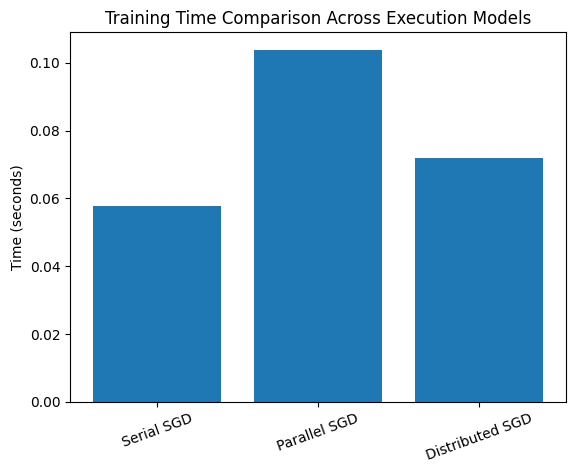

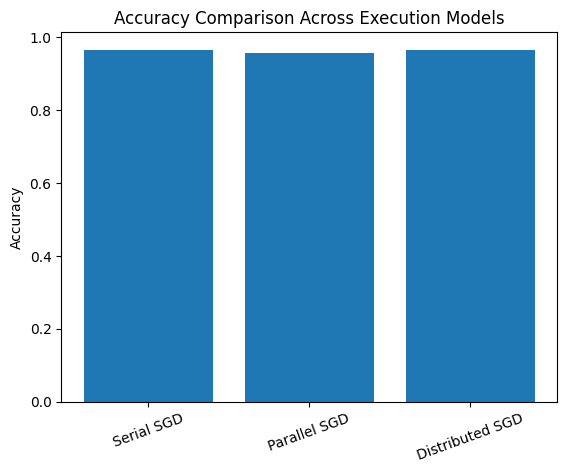

In [9]:
############################################################
# STEP 8 — Visualization of performance results
############################################################

import matplotlib.pyplot as plt

# Prepare data
methods = [
    "Serial SGD",
    "Parallel SGD",
    "Distributed SGD"
]

training_times = [
    time_serial,
    time_parallel,
    time_distributed
]

accuracies = [
    accuracy_serial,
    accuracy_parallel,
    accuracy_distributed
]

############################################################
# Plot 1 — Training time comparison
############################################################

plt.figure()

plt.bar(methods, training_times)

plt.title("Training Time Comparison Across Execution Models")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=20)

plt.show()

############################################################
# Plot 2 — Accuracy comparison
############################################################

plt.figure()

plt.bar(methods, accuracies)

plt.title("Accuracy Comparison Across Execution Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)

plt.show()


## Results Interpretation and Systems Analysis

The following interpretation focuses on system-level insights derived from controlled experimental comparisons rather than model accuracy improvements.

The visual comparison shows clear differences between execution strategies in this experiment.

- Serial SGD achieved the fastest training time. Given the small dataset size and low computational complexity, the overhead of parallel execution outweighs its benefits.

- Shared-memory parallel SGD did not achieve speedup. This is likely due to Python's threading model and execution overhead, where multiple threads compete for shared resources. The results suggest that lock-free parallelism does not always translate to performance gains in practice.

- Distributed SGD introduces periodic synchronization steps. While workers train independently, model averaging adds communication overhead, which increases total execution time in this small-scale setup.

- All execution strategies achieve nearly identical accuracy. This indicates that the optimization process converges similarly regardless of execution model, and that differences are primarily related to system performance rather than model quality.

Overall, these observations highlight that parallelization benefits depend on workload size, execution environment, and system constraints rather than algorithmic design alone. This behaviour is consistent with findings in parallel SGD literature, where achievable speedup is strongly influenced by system overhead and problem scale.

These findings highlight the distinction between algorithmic scalability and system scalability, emphasizing that improved parallelism does not guarantee performance gains without sufficient computational workload.




---

## Version 3 — Design Refinement Through Extended Analysis

Initial experimental results revealed a gap between theoretical expectations of parallel speedup and observed system behaviour. To investigate this further, additional experiments were introduced as a refinement stage of the experimental design. These experiments analyse scalability behaviour, synchronization trade-offs, and workload sensitivity to better understand how execution strategies respond under varying system conditions.

The extended analysis explores how execution models behave under changing computational scenarios, including varying thread counts, synchronization frequency, and workload size. This refinement stage enables deeper systems-level understanding beyond single-configuration comparison.


---

## Additional Experimental Analysis

Following the primary performance evaluation, additional experiments are conducted to further investigate system-level behaviour under varying execution conditions. These experiments extend the analysis by examining scalability characteristics, synchronization trade-offs, and workload-dependent performance trends.

The following experiments examine parallel scaling behaviour, synchronization frequency effects, and workload-dependent scalability characteristics.


### Parallel Scaling Behaviour

This experiment evaluates how increasing the number of parallel worker threads affects execution performance and scalability characteristics.


In [10]:
############################################################
# STEP 9 — Scaling Experiment (Vary number of workers)
#
# Goal:
# - Observe how performance changes with different levels
#   of parallelism.
# - Demonstrate system-level scaling behaviour.
############################################################

thread_options = [1, 2, 4]

scaling_results = []

for num_threads_test in thread_options:

    # Initialize weights
    weights_test = np.zeros(X_train.shape[1])

    data_splits_test = np.array_split(
        np.arange(len(X_train)),
        num_threads_test
    )

    def worker_scaling(indices):
        global weights_test

        # NOTE:
        # Workload (epochs) remains constant while thread count varies.
        # This isolates scaling behaviour from algorithmic workload changes.
        for epoch in range(epochs):
            for i in indices:
                xi = X_train[i]
                yi = y_train[i]

                pred = sigmoid(np.dot(xi, weights_test))
                grad = (pred - yi) * xi

                weights_test -= learning_rate * grad

    threads_test = []

    start = time.time()

    for split in data_splits_test:
        t = threading.Thread(target=worker_scaling, args=(split,))
        threads_test.append(t)
        t.start()

    for t in threads_test:
        t.join()

    elapsed = time.time() - start

    scaling_results.append((num_threads_test, elapsed))

print("\nScaling Experiment Results:")
for threads, ttime in scaling_results:
    print(f"Threads: {threads} | Training Time: {ttime:.4f}")



Scaling Experiment Results:
Threads: 1 | Training Time: 0.0877
Threads: 2 | Training Time: 0.0956
Threads: 4 | Training Time: 0.1094


## Scaling Experiment Interpretation

An additional experiment was performed by varying the number of parallel
threads to observe scaling behaviour.

Results show that increasing parallelism does not necessarily improve
performance in this setup. Due to Python threading overhead and the
Global Interpreter Lock (GIL), additional threads introduce overhead
without significant computational benefit.

This experiment highlights an important systems insight: parallel
scalability depends not only on algorithm design but also on execution
environment and workload size.


In [11]:
############################################################
# Scaling Experiment Table
############################################################

import pandas as pd

scaling_table = pd.DataFrame(
    scaling_results,
    columns=["Number of Threads", "Training Time (seconds)"]
)

print("\nScaling Experiment Table:")
display(scaling_table)



Scaling Experiment Table:


,Number of Threads,Training Time (seconds)
0,1,0.087689
1,2,0.095572
2,4,0.109370


### Synchronization Frequency Study

This experiment analyses how communication frequency impacts distributed training performance, highlighting trade-offs between synchronization overhead and local computation independence.


In [12]:
############################################################
# STEP 10 — Synchronization Frequency Experiment
#
# Goal:
# - Study effect of communication frequency on performance
############################################################

sync_options = [1, 5, 10]

sync_results = []

for sync_test in sync_options:

    local_weights_test = [np.zeros(X_train.shape[1]) for _ in range(num_workers)]

    start = time.time()

    for epoch in range(local_epochs):

        # Local updates
        for worker_id in range(num_workers):

            indices = worker_indices[worker_id]
            w_local = local_weights_test[worker_id]

            for i in indices:
                xi = X_train[i]
                yi = y_train[i]

                pred = sigmoid(np.dot(xi, w_local))
                grad = (pred - yi) * xi

                w_local -= learning_rate * grad

            local_weights_test[worker_id] = w_local

        # Synchronization
        if (epoch + 1) % sync_test == 0:

            avg_weights = np.mean(local_weights_test, axis=0)

            for worker_id in range(num_workers):
                local_weights_test[worker_id] = avg_weights.copy()

    elapsed = time.time() - start

    sync_results.append((sync_test, elapsed))

print("\nSynchronization Frequency Experiment Results:")
for sync_val, ttime in sync_results:
    print(f"sync_interval={sync_val} | Training Time={ttime:.4f}")



Synchronization Frequency Experiment Results:
sync_interval=1 | Training Time=0.1096
sync_interval=5 | Training Time=0.0455
sync_interval=10 | Training Time=0.0662


## Synchronization Frequency Analysis

An additional experiment was conducted to study how synchronization
frequency affects distributed training performance.

Frequent synchronization introduces higher communication overhead,
while less frequent synchronization reduces communication but may
allow local models to diverge temporarily.

The results demonstrate that distributed training involves a tradeoff
between consistency and efficiency, reflecting behaviour discussed
in distributed optimization literature.


In [13]:
############################################################
# Synchronization Frequency Table
############################################################

sync_table = pd.DataFrame(
    sync_results,
    columns=["Synchronization Interval", "Training Time (seconds)"]
)

print("\nSynchronization Experiment Table:")
display(sync_table)



Synchronization Experiment Table:


,Synchronization Interval,Training Time (seconds)
0,1,0.109628
1,5,0.045538
2,10,0.066226


### Workload Scalability Analysis

This experiment studies how execution strategies behave as workload size increases by varying the number of training epochs.


Epoch 1/5 - Loss: 0.1346
Epoch 2/5 - Loss: 0.1042
Epoch 3/5 - Loss: 0.0915
Epoch 4/5 - Loss: 0.0840
Epoch 5/5 - Loss: 0.0789
Epoch 1/10 - Loss: 0.1338
Epoch 2/10 - Loss: 0.1040
Epoch 3/10 - Loss: 0.0912
Epoch 4/10 - Loss: 0.0837
Epoch 5/10 - Loss: 0.0787
Epoch 6/10 - Loss: 0.0750
Epoch 7/10 - Loss: 0.0722
Epoch 8/10 - Loss: 0.0699
Epoch 9/10 - Loss: 0.0680
Epoch 10/10 - Loss: 0.0664
Epoch 1/20 - Loss: 0.1338
Epoch 2/20 - Loss: 0.1038
Epoch 3/20 - Loss: 0.0912
Epoch 4/20 - Loss: 0.0837
Epoch 5/20 - Loss: 0.0787
Epoch 6/20 - Loss: 0.0750
Epoch 7/20 - Loss: 0.0722
Epoch 8/20 - Loss: 0.0699
Epoch 9/20 - Loss: 0.0680
Epoch 10/20 - Loss: 0.0664
Epoch 11/20 - Loss: 0.0651
Epoch 12/20 - Loss: 0.0639
Epoch 13/20 - Loss: 0.0627
Epoch 14/20 - Loss: 0.0618
Epoch 15/20 - Loss: 0.0609
Epoch 16/20 - Loss: 0.0601
Epoch 17/20 - Loss: 0.0594
Epoch 18/20 - Loss: 0.0588
Epoch 19/20 - Loss: 0.0582
Epoch 20/20 - Loss: 0.0576
Epoch 1/40 - Loss: 0.1366
Epoch 2/40 - Loss: 0.1041
Epoch 3/40 - Loss: 0.0916
Epoch

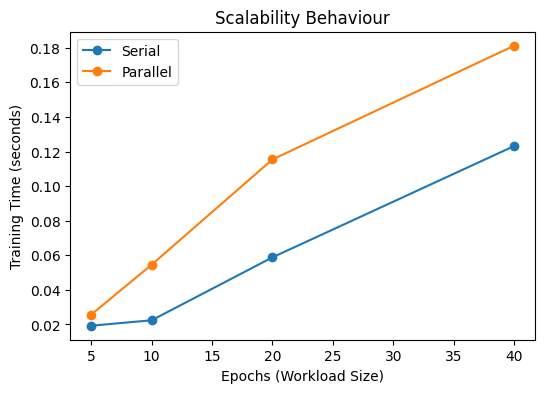

In [18]:
############################################################
# STEP 11 — Workload Scalability Experiment
#
# Goal:
# Study how execution strategies behave as workload increases.
#
# Workload is increased by varying number of training epochs.
# Both serial and parallel execution use identical workloads
# to ensure fair comparison.
############################################################

epoch_values = [5, 10, 20, 40]

serial_times = []
parallel_times = []

############################################################
# Updated parallel worker supporting variable epochs
############################################################
def parallel_worker_scalability(indices, lr, epochs_test):

    global weights_parallel

    for epoch in range(epochs_test):
        for i in indices:
            xi = X_train[i]
            yi = y_train[i]

            pred = sigmoid(np.dot(xi, weights_parallel))
            grad = (pred - yi) * xi

            # Lock-free asynchronous update
            weights_parallel -= lr * grad

############################################################
# Run workload scaling experiment
############################################################

for ep in epoch_values:

    # ---- Serial training ----
    _, _, t_serial = train_serial_sgd(
        X_train,
        y_train,
        lr=learning_rate,
        epochs=ep
    )
    serial_times.append(t_serial)

    # ---- Parallel training ----
    weights_parallel = np.zeros(X_train.shape[1])

    threads = []
    start = time.time()

    for split in data_splits:
        t = threading.Thread(
            target=parallel_worker_scalability,
            args=(split, learning_rate, ep)
        )
        threads.append(t)
        t.start()

    for t in threads:
        t.join()

    t_parallel = time.time() - start
    parallel_times.append(t_parallel)

print("Workload scalability experiment complete.")

############################################################
# Plot scalability behaviour
############################################################

plt.figure(figsize=(6,4))

plt.plot(epoch_values, serial_times, marker='o', label="Serial")
plt.plot(epoch_values, parallel_times, marker='o', label="Parallel")

plt.xlabel("Epochs (Workload Size)")
plt.ylabel("Training Time (seconds)")
plt.title("Scalability Behaviour")
plt.legend()

plt.show()


## Workload Scalability Analysis

This experiment evaluates how execution performance changes as computational workload increases. Workload is controlled by varying the number of training epochs while keeping the dataset, model configuration, and algorithmic parameters fixed. This ensures that observed behaviour reflects execution scalability rather than differences in model design.

Instead of modifying dataset size, workload intensity is increased by adjusting the number of training epochs. This approach isolates how execution strategies respond to increasing computational demand under controlled conditions.

Both serial and parallel implementations perform identical optimization work for each workload setting, ensuring that observed performance trends reflect execution scalability rather than differences in training procedure. This controlled setup isolates system-level effects as computational intensity increases.

### Observations

- Serial execution scales predictably with workload size and remains the most efficient execution strategy in this experimental setting.

- Parallel execution introduces additional overhead related to thread management, shared-memory contention, and Python runtime constraints. These overheads dominate performance across all tested workload sizes.

- As workload increases, both execution strategies show approximately linear growth in training time; however, parallel execution continues to exhibit higher runtime cost. This indicates that coordination overhead is not sufficiently amortized by the increased computational workload under the current experimental conditions.

These results illustrate an important systems principle: the benefits of parallelism depend on the balance between computational workload and coordination overhead. In this setup, overhead remains the dominant factor, preventing parallel execution from achieving efficiency gains relative to serial execution.

This behaviour highlights the distinction between theoretical parallel scalability and practical execution efficiency, emphasizing the role of runtime environment constraints such as Python threading overhead, synchronization costs, and shared-resource contention.

These experiments demonstrate that execution performance is governed not only by algorithm design but also by implementation details, runtime behaviour, and workload granularity. Such observations reinforce the importance of systems-level evaluation when studying distributed machine learning.

*Note: Minor variation in timing results across runs is expected due to stochastic data ordering and non-deterministic scheduling in lock-free parallel execution.*


## Visualization of Consolidated Experimental Results

To support systems-level interpretation and provide a unified overview of experimental outcomes, consolidated visualizations are created comparing execution strategies across key performance metrics.

These visualizations summarize training time, prediction accuracy, and relative speedup across serial, shared-memory parallel, and distributed implementations. Presenting results in a unified visual format helps reinforce comparative analysis and improves interpretability of execution-level trade-offs observed throughout the experiments.

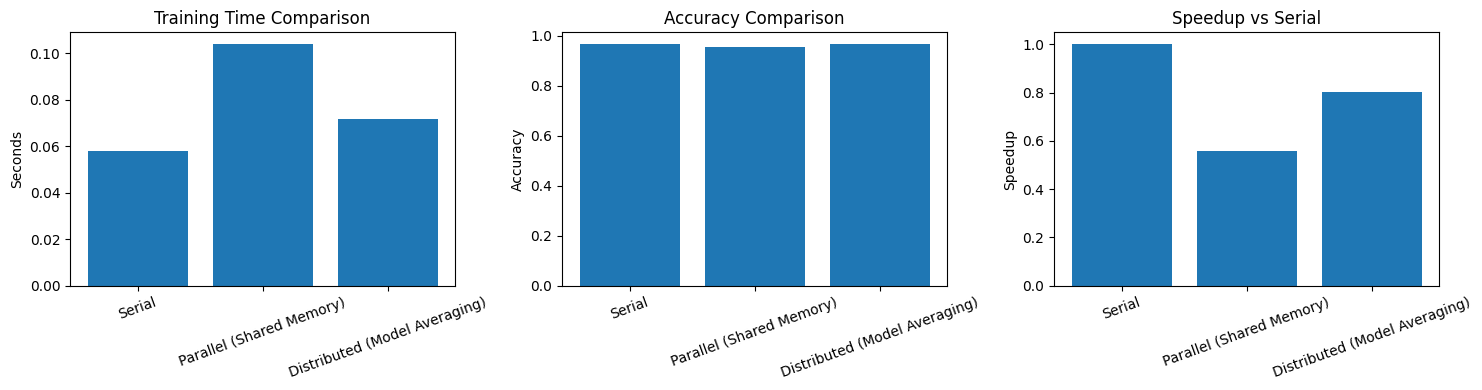

In [15]:
############################################################
# STEP 12 — Consolidated Performance Visualization
#
# Goal:
# - Present results like research paper figures
############################################################

import matplotlib.pyplot as plt

# Prepare data
methods = [
    "Serial",
    "Parallel (Shared Memory)",
    "Distributed (Model Averaging)"
]

training_times = [
    time_serial,
    time_parallel,
    time_distributed
]

accuracies = [
    accuracy_serial,
    accuracy_parallel,
    accuracy_distributed
]

# Speedup relative to serial
speedups = [
    1.0,
    time_serial / time_parallel,
    time_serial / time_distributed
]

############################################################
# Create figure with 3 subplots
############################################################

plt.figure(figsize=(15,4))

# ---- Training Time ----
plt.subplot(1,3,1)
plt.bar(methods, training_times)
plt.title("Training Time Comparison")
plt.ylabel("Seconds")
plt.xticks(rotation=20)

# ---- Accuracy ----
plt.subplot(1,3,2)
plt.bar(methods, accuracies)
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)

# ---- Speedup ----
plt.subplot(1,3,3)
plt.bar(methods, speedups)
plt.title("Speedup vs Serial")
plt.ylabel("Speedup")
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()


## Consolidated Performance Visualization

This visualization summarizes the performance of different SGD execution strategies.

The comparison highlights:

- Training time differences between serial, shared-memory parallel,
  and distributed implementations.

- Accuracy consistency across execution models, confirming that
  system-level changes did not affect convergence quality.

- Speedup behaviour relative to the serial baseline.

The results demonstrate that parallelization benefits depend on
execution environment, workload size, and communication overhead,
which aligns with system-level optimization principles discussed
in distributed learning literature.


---

Before presenting a consolidated systems-level comparison, the following retrospective summary synthesizes how observations from each experiment informed subsequent design refinements. Unlike the earlier Experiment Evolution Overview, which introduced the planned workflow, this section reflects on the completed experiments to highlight key systems insights derived at each stage.

## Design Evolution Summary

The experimental workflow progressed through multiple design stages, where observations from each implementation informed subsequent refinements. The table below summarizes the evolution of execution strategies and the key insights derived from each stage.

| Version | Execution Strategy | Motivation | Observed Behaviour | Key Insight |
|---|---|---|---|---|
| Version 0 | Serial SGD Baseline | Establish reference performance | Fastest execution for small workload | Low coordination overhead dominates performance |
| Version 1 | Shared-Memory Parallel (Lock-Free) | Improve efficiency via intra-machine parallelism | No speedup observed | Python runtime constraints and overhead limit scalability |
| Version 2 | Distributed Data-Parallel (Model Averaging) | Explore alternative execution architecture | Synchronization overhead introduced | Communication costs impact distributed performance |
| Version 3 | Extended Analysis Experiments | Investigate theoretical vs practical gap | Scaling behaviour and workload sensitivity observed | Parallel efficiency depends on workload size and system environment |

This summary highlights how iterative experimentation refined understanding of system-level trade-offs affecting machine learning execution strategies.


---

## Comparative Systems Analysis


In [16]:
############################################################
# MASTER EXPERIMENT COMPARISON TABLE
#
# Goal:
# Combine key experiment results into one structured table
# for analysis and reporting.
############################################################

import pandas as pd

master_results = []

# ---- Serial baseline ----
master_results.append({
    "Execution Model": "Serial",
    "Threads/Workers": 1,
    "Sync Interval": "N/A",
    "Training Time": time_serial,
    "Accuracy": accuracy_serial,
    "Speedup vs Serial": 1.0
})

# ---- Parallel shared-memory ----
master_results.append({
    "Execution Model": "Parallel (Shared Memory)",
    "Threads/Workers": num_threads,
    "Sync Interval": "N/A",
    "Training Time": time_parallel,
    "Accuracy": accuracy_parallel,
    "Speedup vs Serial": time_serial / time_parallel
})

# ---- Distributed model averaging ----
master_results.append({
    "Execution Model": "Distributed (Model Averaging)",
    "Threads/Workers": num_workers,
    "Sync Interval": sync_interval,
    "Training Time": time_distributed,
    "Accuracy": accuracy_distributed,
    "Speedup vs Serial": time_serial / time_distributed
})

# Convert to dataframe
master_table = pd.DataFrame(master_results)

print("\n===== MASTER COMPARISON TABLE =====")
display(master_table)



===== MASTER COMPARISON TABLE =====


,Execution Model,Threads/Workers,Sync Interval,Training Time,Accuracy,Speedup vs Serial
0,Serial,1,N/A,0.057831,0.964912,1.000000
1,Parallel (Shared Memory),2,N/A,0.103834,0.956140,0.556956
2,Distributed (Model Averaging),2,5,0.071925,0.964912,0.804045


### Master Experimental Comparison

To enable structured systems-level comparison, experimental outcomes are consolidated into a unified master comparison table summarizing execution strategies, configuration parameters, and performance metrics.

This structured representation supports clearer interpretation of how system factors — including execution model, degree of parallelism, and synchronization frequency — influence training time, accuracy, and relative speedup.

Presenting results in tabular form enables systematic comparison across execution strategies and reinforces the analytical and systems-focused nature of the study.


## Experimental Methodology Summary

The experiments were designed to isolate system-level effects introduced by different execution strategies while maintaining identical algorithmic behaviour.

A controlled experimental framework was used in which the dataset, preprocessing pipeline, model architecture, optimization procedure, and hyperparameters remained fixed across all experiments. Only execution-related parameters — including execution model, number of threads/workers, and synchronization frequency — were varied.

Across all experiments:

- The same dataset and preprocessing pipeline were used.
- Learning rate, training epochs, and evaluation metrics were kept constant.
- Performance was measured using training time, accuracy, and relative speedup.

This controlled setup ensures that observed differences reflect execution strategy and system-level behaviour rather than algorithmic changes. Results should therefore be interpreted as an analysis of execution efficiency and scalability rather than model performance improvement.

Such controlled experimentation aligns with standard evaluation practices in distributed and parallel machine learning systems, where performance depends on both computational workload and coordination overhead.


## Experimental Limitations and Practical Considerations

While the experiments provide insight into execution behaviour across serial, parallel, and distributed settings, several practical limitations should be noted.

- The dataset used is relatively small, which limits the observable benefits of parallel execution. In larger workloads, computational cost may dominate overhead, potentially changing performance trends.

- Shared-memory parallelism was implemented using Python threading, which is subject to the Global Interpreter Lock (GIL). As a result, true CPU-level parallelism may not be fully realized.

- Distributed training was simulated within a single runtime environment rather than executed across physically separate machines. Therefore, communication overhead represents an approximation rather than real network latency.

- Hardware configuration and runtime environment can influence observed performance, and results should be interpreted relative to the specific experimental setup.

These considerations highlight that experimental findings reflect both algorithmic behaviour and system-level constraints, reinforcing the importance of evaluating machine learning systems holistically. Future evaluation on larger datasets, alternative parallel execution frameworks, or real distributed environments may provide additional insights into scalability behaviour.

## Systems-Level Trade-off Analysis


The experiments highlight that improving execution performance is not solely a matter of increasing parallelism. Instead, system-level trade-offs emerge between computation, coordination overhead, and execution environment constraints.

Key trade-offs observed include:

- **Parallelism vs Overhead:** While parallel execution introduces additional computational resources, thread management and synchronization overhead can outweigh benefits for small workloads.

- **Consistency vs Communication:** Distributed training reduces contention by allowing independent local updates, but periodic synchronization introduces communication costs that influence total execution time.

- **Implementation Simplicity vs Performance Efficiency:** Lock-free updates simplify implementation but may introduce resource contention and limit performance gains under certain runtime conditions.

These observations reinforce an important principle in distributed machine learning systems: scalability depends on the interaction between algorithm design, workload characteristics, and system architecture rather than any single optimization strategy.

Understanding these trade-offs is essential when selecting execution models for real-world machine learning pipelines.


---

## Key Findings Summary

The following summary synthesizes system-level insights derived from the experimental evaluation.

The experiments demonstrate that execution strategy significantly influences training performance even when the underlying learning algorithm remains unchanged.

Key observations include:

- **Serial execution** achieved the lowest training time due to minimal overhead on small workloads.
- **Shared-memory parallel execution** maintained accuracy but did not provide speedup because coordination overhead and Python runtime constraints dominated computation.
- Distributed model averaging introduced synchronization overhead, highlighting trade-offs between communication frequency and independent computation.
- Accuracy remained consistent across execution strategies, indicating that performance differences primarily arise from system-level factors rather than optimization behaviour.

Overall, results emphasize that scalability depends on the interaction between workload size, execution environment, and system architecture rather than parallelism alone.

From a broader systems perspective, these findings reveal that scalability in machine learning is fundamentally constrained by the interaction between algorithm design and execution environment. While stochastic gradient descent is theoretically well-suited for parallel and distributed execution, practical performance gains depend heavily on workload granularity, synchronization strategy, runtime constraints, and communication overhead. The experiments demonstrate that increasing parallelism alone does not guarantee improved efficiency; instead, effective system performance arises when computational intensity sufficiently outweighs coordination costs. This highlights an important principle in ML systems engineering: optimization must consider the complete execution stack — including hardware architecture, runtime behaviour, and implementation choices — rather than focusing solely on algorithmic parallelism.



## Future Work and Extensions

While this study focuses on controlled experimental comparison of execution strategies, several practical extensions could further deepen understanding:

- Evaluating performance on larger datasets where computational workload dominates coordination overhead.
- Exploring multiprocessing or alternative parallel frameworks to overcome Python threading limitations.
- Running experiments on real distributed environments to observe realistic communication behaviour.

These extensions would help bridge the gap between controlled educational experiments and real-world distributed machine learning systems.
